# Laplacian Associative Memory (LAM) - DEV 10

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

- Arc Tangent (Radians)
- Gabor Filter
- Optimize & Comments

In [1]:
from nn import LAM
import libtools

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# np.random.seed(123)

In [4]:
src = np.load('../data/mat/SOM_orient_v1.npy')
src = libtools.downsample(src, 4)

(51, 51)
Theta θ | min: 0.0012 max: 6.282


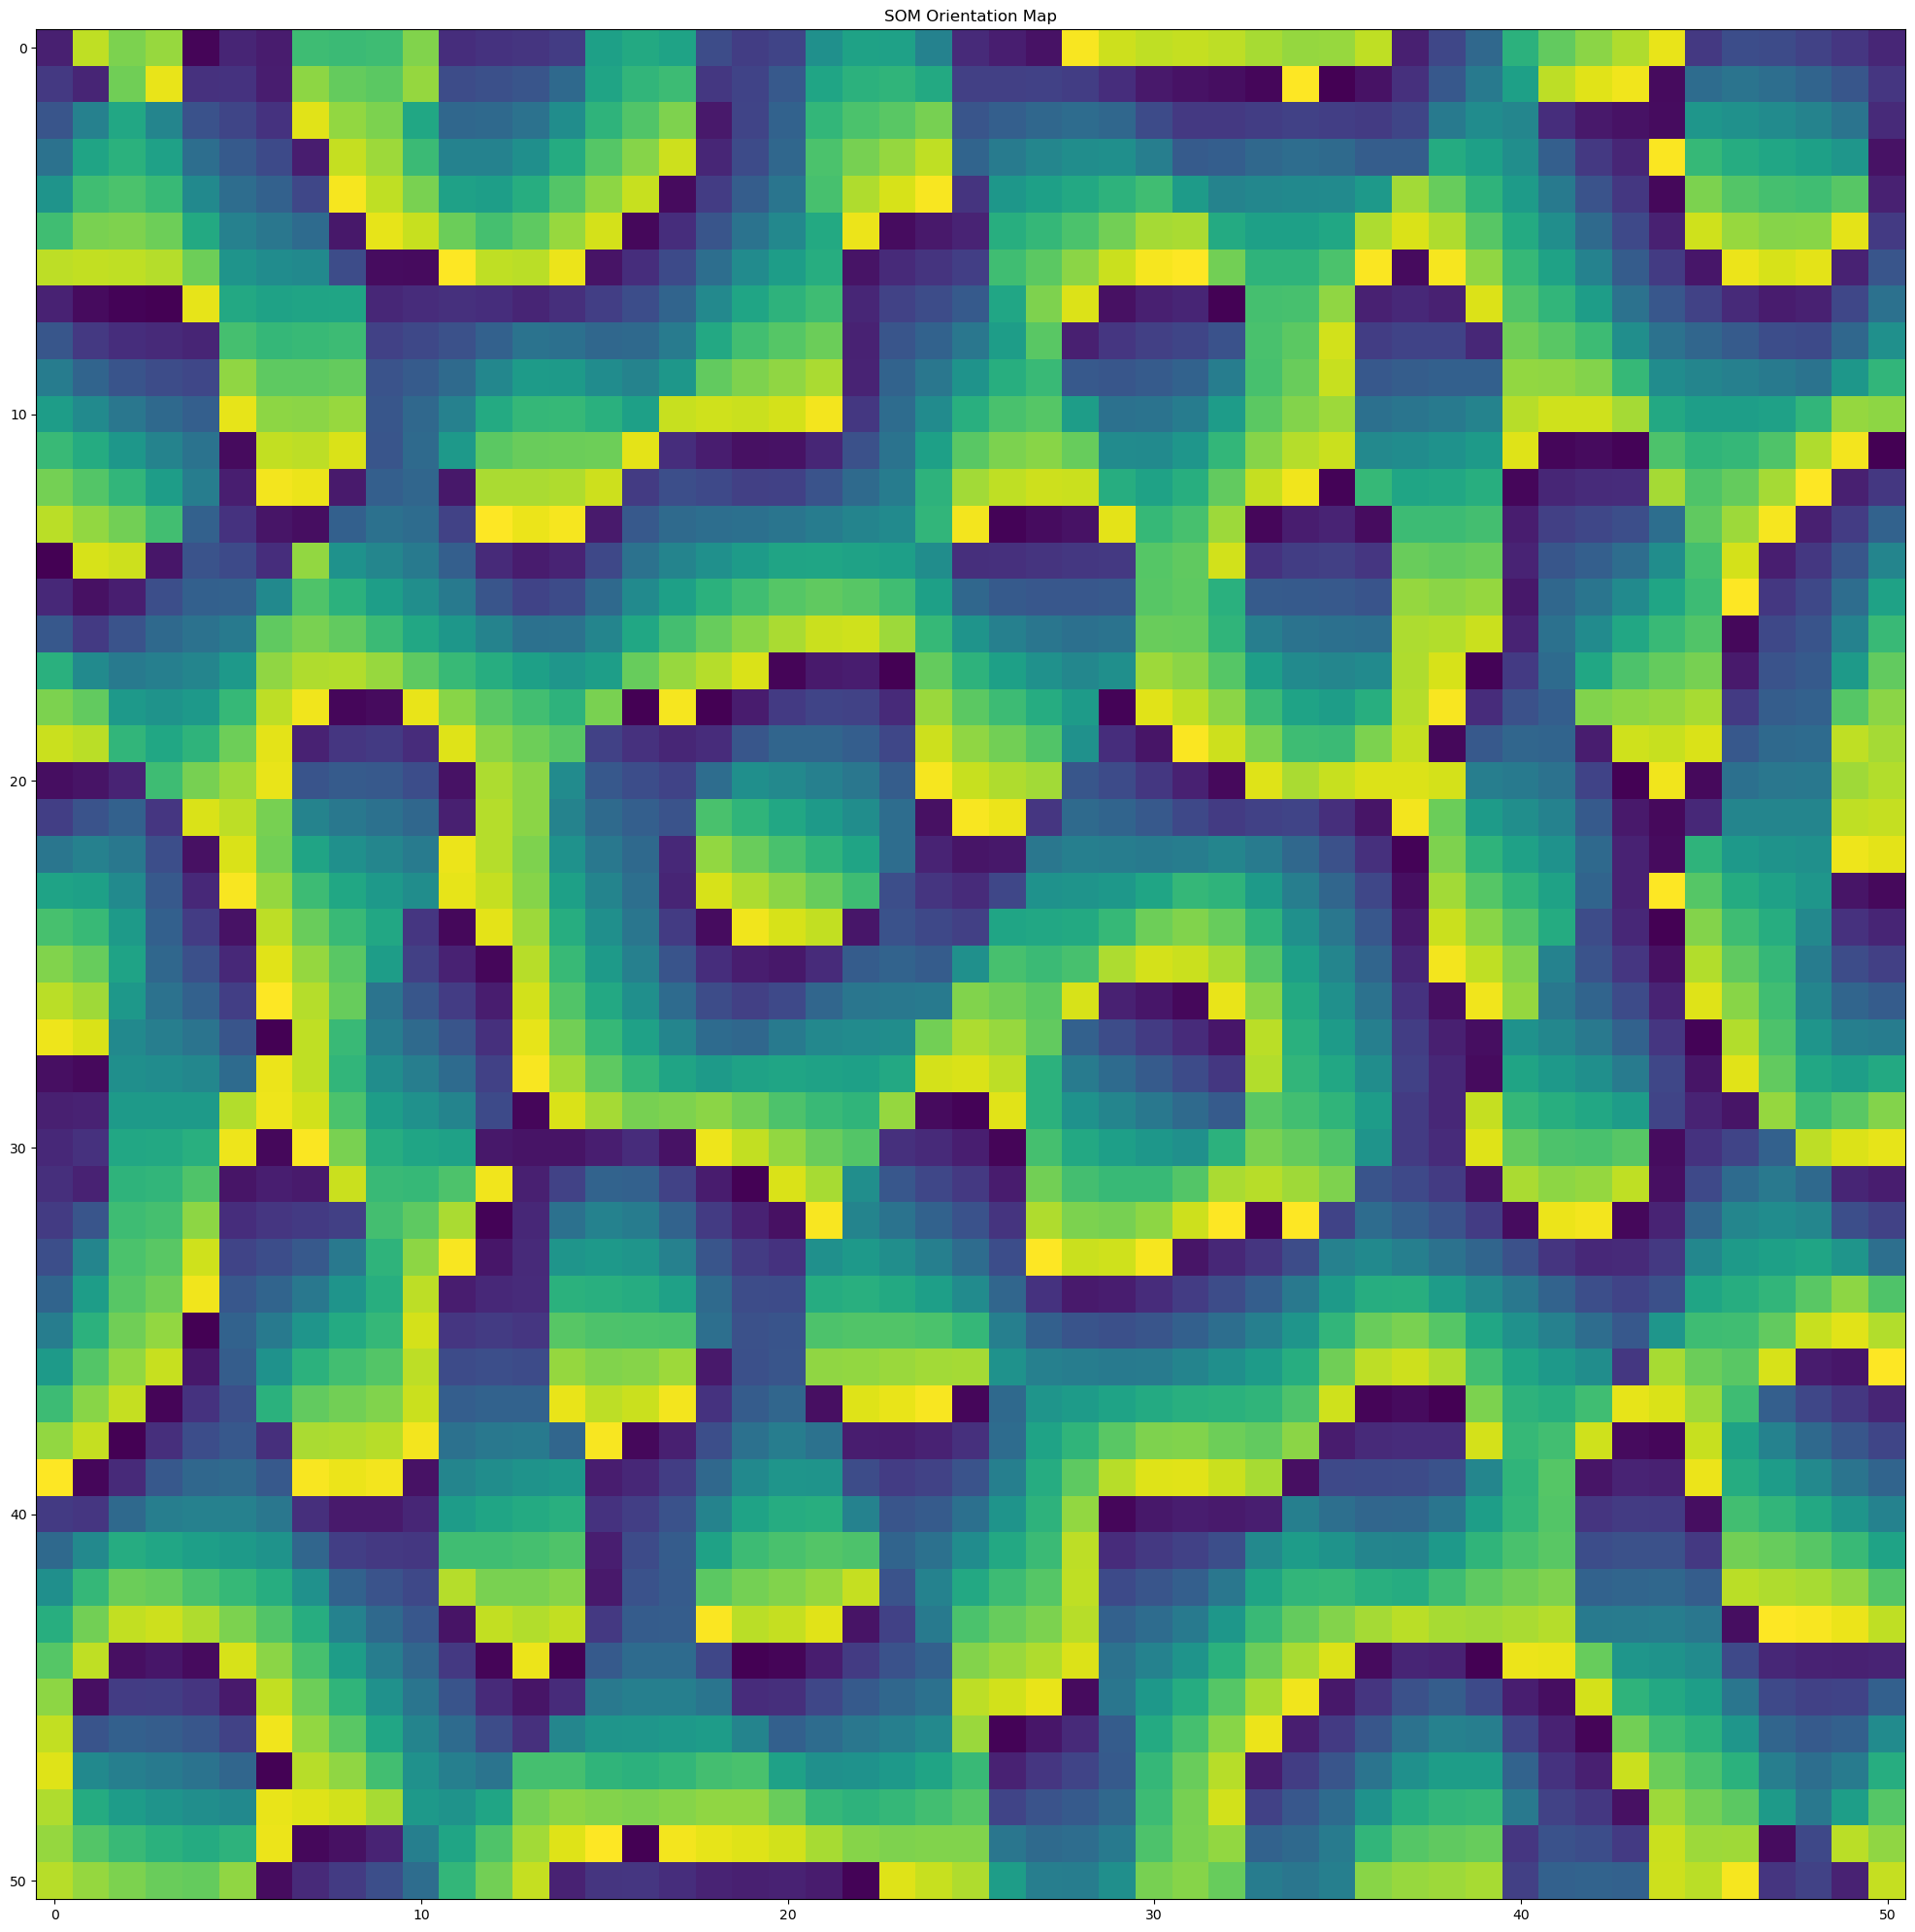

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(src)
plt.title('SOM Orientation Map')
plt.tight_layout()

print(src.shape)
print('Theta θ | min:', round(src.min(),4), 'max:', round(src.max(),4))

---

### ANGULAR COMPONENT

In [6]:
features = np.zeros_like(src)
for i in range(src.shape[0]):
    for j in range(src.shape[1]):
        x = src[i][j] - np.pi # Arc tangent | -π and π
        deg = np.rad2deg(x*0.5) # *0.5 to keep range between -90 and 90
        kernel = libtools.gabor_filter(2, 1, deg) # Orientation
        features[i][j] = np.sum(x * kernel) # Firing Rate / Response

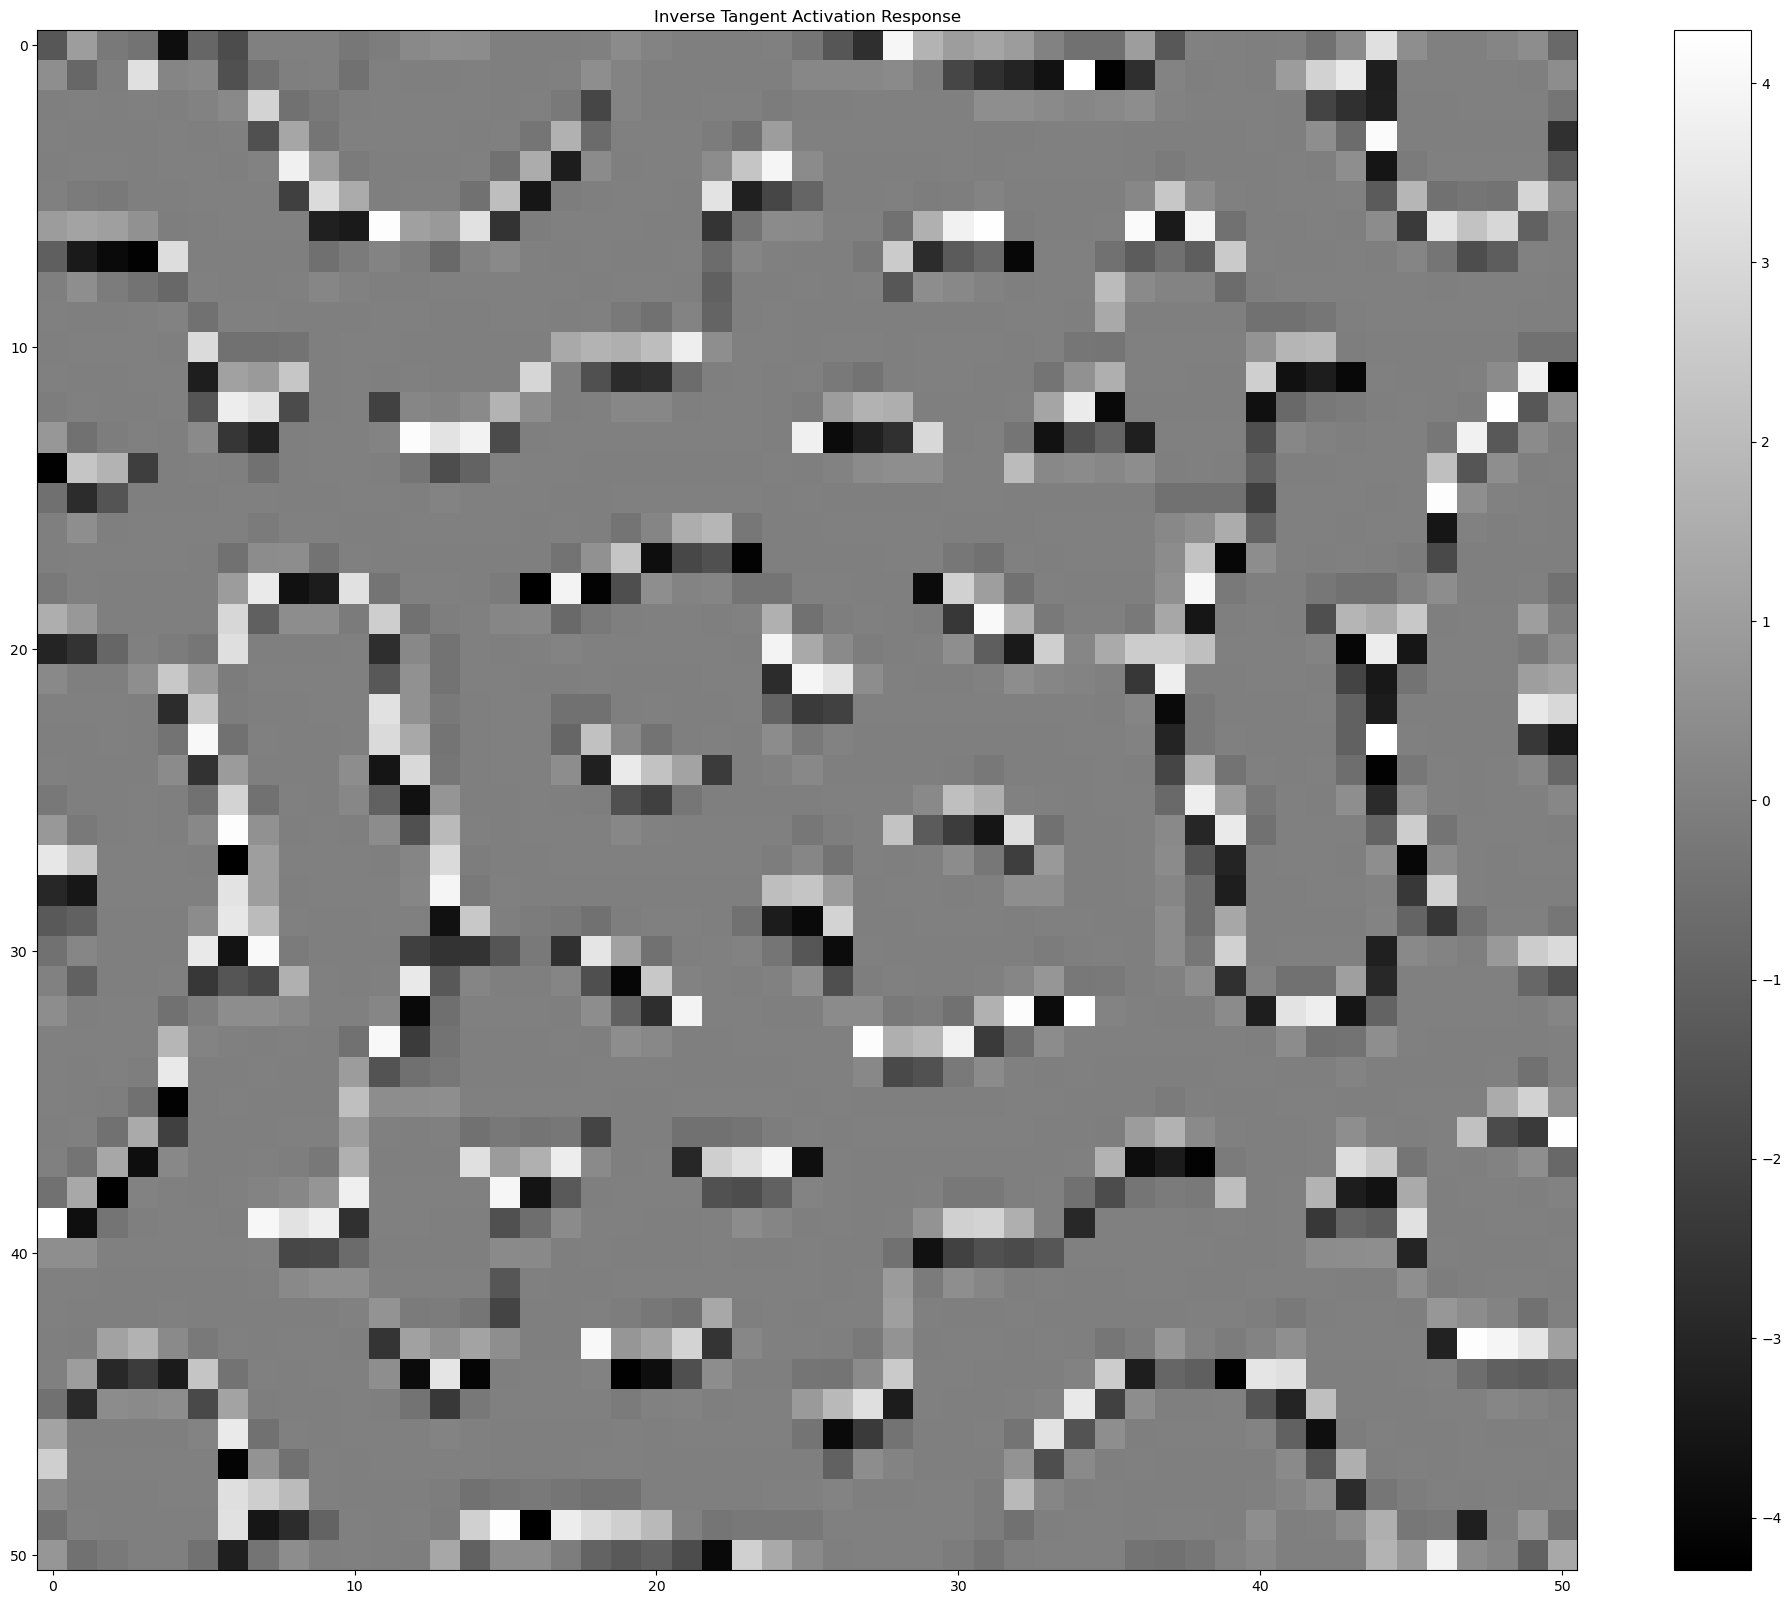

In [7]:
plt.figure(figsize=(25,20))
plt.imshow(features, 'gray')
plt.title('Inverse Tangent Activation Response')
plt.colorbar()

---

### COMPUTE GRAPH

In [8]:
N = 4096                            # Neurons | Default: 30000
prob = 0.1                          # Sparsity
eta = 0.01                          # Epsilon / Learning rate
epochs = 3000                       # Steps
gamma = 0.6                         # Inhibition ratio
norm_mode = 'asym'                  # Asymmetric Normalisation
alpha = -0.9                        # Ratio betwen local and global inhibition
P = src.shape[0] * src.shape[1]     # N Nodes

rad = 5                             # Radius of receptive field / kernel
sigmaX = 4.0                        # Spatial Gaussian Scale
sigmaA = 1.0                        # Angular Component Gaussian Scale

# Init condition (Center cell)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))
print('Start node:', start_node)

Start node: 1300


In [9]:
# Construct matrix
W = libtools.construct_SOAM(src, rad, sigmaX, sigmaA)

In [10]:
# Build graph
graph = LAM(N, P, prob, W, gamma, norm_mode)

In [11]:
# Graph Laplacian (GL) Eigenvectors
_, v = libtools.GL_eigen(W, norm_mode)

In [12]:
# Simulate LAM
graph._set_weight(alpha)
m_log, _ = graph.simulate_single(alpha, eta, epochs, start_node)
m = m_log[-1,:]

100%|██████████| 3000/3000 [00:28<00:00, 104.14it/s]


Text(0.5, 1.0, 'SOAM | alpha=-0.9')

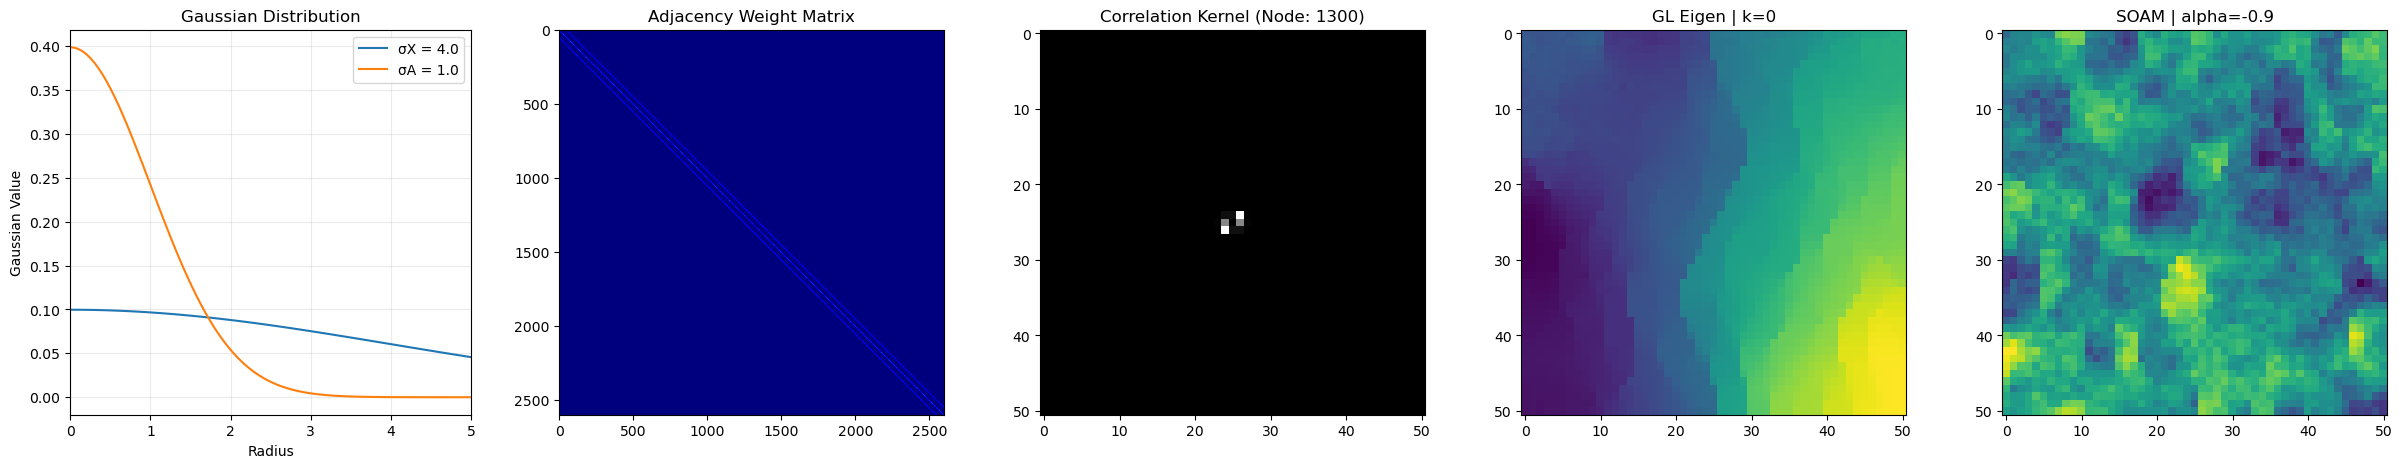

In [13]:
plt.figure(figsize=(30,5))
plt.subplot(1, 5, 1)
dist = np.linspace(0, rad, 100)
plt.plot(dist, libtools.gaussian(dist, sigmaX), label=f'σX = {sigmaX}')
plt.plot(dist, libtools.gaussian(dist, sigmaA), label=f'σA = {sigmaA}')
plt.title('Gaussian Distribution')
plt.xlabel('Radius'), plt.ylabel('Gaussian Value')
plt.xlim([0, rad]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(1, 5, 2)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(1, 5, 3)
plt.imshow(W[start_node].reshape(src.shape), 'gray')
plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

plt.subplot(1, 5, 4)
k = 0
plt.imshow(v[:,k].reshape(src.shape), vmin=np.min(v[:,k]), vmax=np.max(v[:,k]))
plt.title('GL Eigen | k='+ str(k))

plt.subplot(1, 5, 5)
plt.imshow(m.reshape(src.shape), vmin=np.min(m), vmax=np.max(m))
plt.title('SOAM | alpha=' + str(alpha))